In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import copy
import time
from tqdm import tqdm
import os

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split

In [3]:
import timm
from timm.loss import LabelSmoothingCrossEntropy
from timm.data import create_transform

In [4]:
print(torch.__version__)
print(torchvision.__version__)

2.0.0
0.15.0


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
import numpy as np
from torchvision import models

In [7]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [8]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.1),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#             transforms.RandomErasing(p=0.25, value='random')
        ])
        all_data = datasets.ImageFolder(data_dir, transform=transform)
        train_data_len = int(len(all_data)*0.75)
        valid_data_len = int((len(all_data) - train_data_len)/2)
        test_data_len = int(len(all_data) - train_data_len - valid_data_len)
        train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, train_data_len
    
    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        all_data = datasets.ImageFolder(data_dir, transform=transform)
        train_data_len = int(len(all_data)*0.70)
        valid_data_len = int((len(all_data) - train_data_len)/2)
        test_data_len = int(len(all_data) - train_data_len - valid_data_len)
        train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return (val_loader, test_loader, valid_data_len, test_data_len)

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
dataset_path = "CUB_200_2011/images/"
(train_loader, train_data_len) = get_data_loaders(dataset_path, 256, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 64, train=False)
classes = get_classes(dataset_path)

In [11]:
dataloaders = {
    "train":train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train":train_data_len,
    "val": valid_data_len
}

In [12]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

35
28
28


In [13]:
print(train_data_len, test_data_len, valid_data_len)

8841 1769 1768


In [14]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [14]:
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2

# 定义中值滤波函数
def median_filter(image, kernel_size=3):
    # 转换为NumPy数组
    image_np = image.permute(1, 2, 0).cpu().numpy()
    # 中值滤波
    filtered_image = cv2.medianBlur(image_np, kernel_size)
    # 将结果转换回PyTorch张量
    filtered_image = torch.from_numpy(filtered_image).permute(2, 0, 1).float()
    return filtered_image

# 定义高斯滤波函数
def gaussian_filter(image, kernel_size=3, sigma=1.0):
    # 转换为NumPy数组
    image_np = image.permute(1, 2, 0).cpu().numpy()
    # 高斯滤波
    filtered_image = cv2.GaussianBlur(image_np, (kernel_size, kernel_size), sigma)
    # 将结果转换回PyTorch张量
    filtered_image = torch.from_numpy(filtered_image).permute(2, 0, 1).float()
    return filtered_image

In [16]:
def plot_images(images, labels, normalize=True, apply_median_filter=False, apply_gaussian_filter=False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if apply_median_filter:
            image = median_filter(image)

        if apply_gaussian_filter:
            image = gaussian_filter(image)

        if normalize:
            image = normalize_image(image)
        
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = labels[i]
        ax.set_title(label)
        ax.axis('off')

LBP特征形状: (10,)
HOG特征形状: (116388,)
HOG特征: [0.24913321 0.08546249 0.10810244 ... 0.0397807  0.04193254 0.05930157]


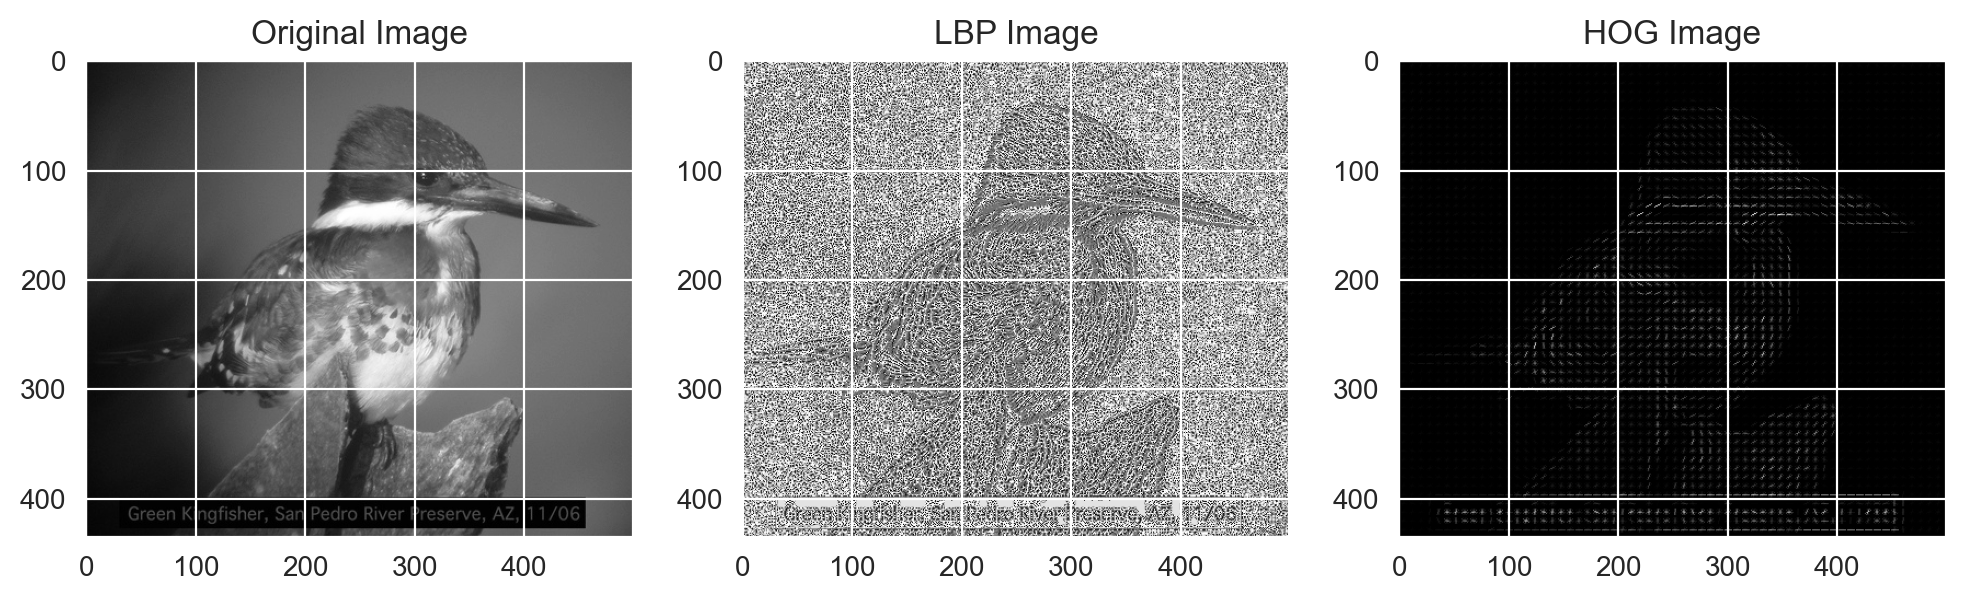

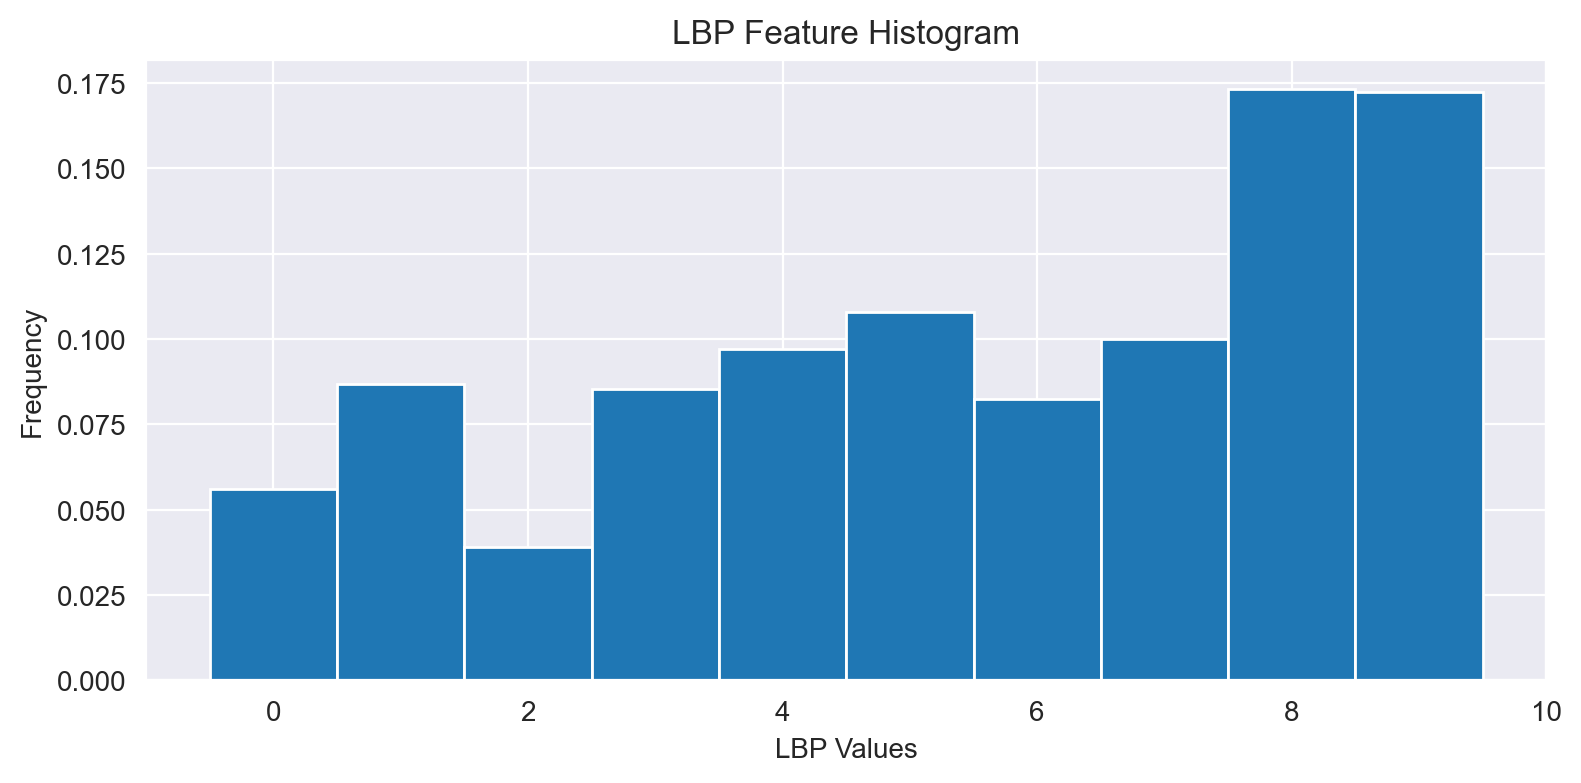

In [15]:
import cv2
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np

# 读取图像
image = cv2.imread('CUB_200_2011/images/080.Green_Kingfisher/Green_Kingfisher_0027_71048.jpg', cv2.IMREAD_GRAYSCALE)  # 读取为灰度图像

# 提取LBP特征
radius = 1  # LBP半径
n_points = 8 * radius  # 邻域点数
lbp_image = local_binary_pattern(image, n_points, radius, method='uniform')

# 计算LBP直方图
lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, n_points + 3), density=True)

# 提取HOG特征
orientations = 9  # HOG方向数量
pixels_per_cell = (8, 8)  # 细胞大小
cells_per_block = (2, 2)  # 每个块包含的细胞数量

# 使用HOG函数提取特征
hog_features, hog_image = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                              cells_per_block=cells_per_block, visualize=True)

# 输出特征的形状
print("LBP特征形状:", lbp_hist.shape)
print("HOG特征形状:", hog_features.shape)
print("HOG特征:", hog_features)

# 展示图像和特征
plt.figure(figsize=(12, 6))

# 原始图像
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

# LBP特征图像
plt.subplot(132)
plt.imshow(lbp_image, cmap='gray')
plt.title('LBP Image')

# HOG特征图像
plt.subplot(133)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Image')

# 展示LBP特征直方图
plt.figure(figsize=(8, 4))
plt.bar(range(0, n_points + 2), lbp_hist, width=1)
plt.xlabel('LBP Values')
plt.ylabel('Frequency')
plt.title('LBP Feature Histogram')

plt.tight_layout()
plt.show()


In [16]:
print(hog_features)

[0.24913321 0.08546249 0.10810244 ... 0.0397807  0.04193254 0.05930157]


In [16]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
# model = torch.hub.load('facebookresearch/deit:main', 'resmlp_12', pretrained=True)
torch.backends.cudnn.benchmark = True
model = torchvision.models.efficientnet_b0(pretrained=True)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [20]:
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Linear(n_inputs,2048),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, len(classes))
)

model = model.to(device)
print(model.classifier)

Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=2048, out_features=200, bias=True)
)


In [22]:
print(f"Trainable Params: {count_parameters(model)}")

Trainable Params: 3033288


In [21]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
criterion = criterion.to(device)
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)
# optimizer = optim.SGD(model.classifier.parameters(), lr=0.01, momentum=0.9, nesterov=True)

In [22]:
step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.96)

In [23]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'D:\py_workspace\Bird Classification\Best_model.pth')
    return model

In [28]:
model_ft = train_model(model, criterion, optimizer, step_scheduler,
                       num_epochs=20)

Epoch 0/19
----------


100%|██████████| 35/35 [03:06<00:00,  5.33s/it]


train Loss: 4.5669 Acc: 0.1913


100%|██████████| 28/28 [00:30<00:00,  1.10s/it]


val Loss: 3.3832 Acc: 0.4932

Epoch 1/19
----------


100%|██████████| 35/35 [01:16<00:00,  2.19s/it]


train Loss: 3.3618 Acc: 0.4924


100%|██████████| 28/28 [00:20<00:00,  1.34it/s]


val Loss: 2.8850 Acc: 0.6646

Epoch 2/19
----------


100%|██████████| 35/35 [01:11<00:00,  2.04s/it]


train Loss: 2.9808 Acc: 0.6228


100%|██████████| 28/28 [00:29<00:00,  1.06s/it]


val Loss: 2.6829 Acc: 0.7421

Epoch 3/19
----------


100%|██████████| 35/35 [01:18<00:00,  2.25s/it]


train Loss: 2.7953 Acc: 0.6908


100%|██████████| 28/28 [00:31<00:00,  1.13s/it]


val Loss: 2.5568 Acc: 0.7749

Epoch 4/19
----------


100%|██████████| 35/35 [01:04<00:00,  1.86s/it]


train Loss: 2.6515 Acc: 0.7451


100%|██████████| 28/28 [00:17<00:00,  1.58it/s]


val Loss: 2.4629 Acc: 0.7998

Epoch 5/19
----------


100%|██████████| 35/35 [00:26<00:00,  1.30it/s]


train Loss: 2.5490 Acc: 0.7810


100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


val Loss: 2.4098 Acc: 0.8275

Epoch 6/19
----------


100%|██████████| 35/35 [00:27<00:00,  1.30it/s]


train Loss: 2.4533 Acc: 0.8212


100%|██████████| 28/28 [00:14<00:00,  2.00it/s]


val Loss: 2.3507 Acc: 0.8462

Epoch 7/19
----------


100%|██████████| 35/35 [00:28<00:00,  1.22it/s]


train Loss: 2.3756 Acc: 0.8457


100%|██████████| 28/28 [00:17<00:00,  1.61it/s]


val Loss: 2.2941 Acc: 0.8597

Epoch 8/19
----------


100%|██████████| 35/35 [00:29<00:00,  1.19it/s]


train Loss: 2.3113 Acc: 0.8692


100%|██████████| 28/28 [00:14<00:00,  1.88it/s]


val Loss: 2.2577 Acc: 0.8739

Epoch 9/19
----------


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


train Loss: 2.2602 Acc: 0.8897


100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


val Loss: 2.2323 Acc: 0.8784

Epoch 10/19
----------


100%|██████████| 35/35 [00:27<00:00,  1.25it/s]


train Loss: 2.2024 Acc: 0.9074


100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


val Loss: 2.1918 Acc: 0.8880

Epoch 11/19
----------


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


train Loss: 2.1597 Acc: 0.9208


100%|██████████| 28/28 [00:14<00:00,  1.91it/s]


val Loss: 2.1642 Acc: 0.8937

Epoch 12/19
----------


100%|██████████| 35/35 [00:27<00:00,  1.28it/s]


train Loss: 2.1225 Acc: 0.9330


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


val Loss: 2.1478 Acc: 0.8920

Epoch 13/19
----------


100%|██████████| 35/35 [00:26<00:00,  1.31it/s]


train Loss: 2.0819 Acc: 0.9438


100%|██████████| 28/28 [00:14<00:00,  1.94it/s]


val Loss: 2.1245 Acc: 0.9016

Epoch 14/19
----------


100%|██████████| 35/35 [00:27<00:00,  1.28it/s]


train Loss: 2.0562 Acc: 0.9502


100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


val Loss: 2.1178 Acc: 0.8993

Epoch 15/19
----------


100%|██████████| 35/35 [00:27<00:00,  1.29it/s]


train Loss: 2.0394 Acc: 0.9554


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


val Loss: 2.1017 Acc: 0.9016

Epoch 16/19
----------


100%|██████████| 35/35 [00:27<00:00,  1.29it/s]


train Loss: 2.0056 Acc: 0.9640


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


val Loss: 2.0901 Acc: 0.9050

Epoch 17/19
----------


100%|██████████| 35/35 [00:27<00:00,  1.29it/s]


train Loss: 1.9897 Acc: 0.9687


100%|██████████| 28/28 [00:14<00:00,  1.98it/s]


val Loss: 2.0774 Acc: 0.9078

Epoch 18/19
----------


100%|██████████| 35/35 [00:27<00:00,  1.28it/s]


train Loss: 1.9654 Acc: 0.9742


100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


val Loss: 2.0691 Acc: 0.9010

Epoch 19/19
----------


100%|██████████| 35/35 [00:27<00:00,  1.29it/s]


train Loss: 1.9467 Acc: 0.9779


100%|██████████| 28/28 [00:14<00:00,  1.97it/s]


val Loss: 2.0638 Acc: 0.9038

Training complete in 20m 52s
Best val Acc: 0.907805


In [29]:
torch.cuda.empty_cache()

In [25]:
%%time
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model_ft.eval()

for data, target in tqdm(test_loader):
    if torch.cuda.is_available(): 
        data, target = data.cuda(), target.cuda()
    with torch.no_grad():
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 64:
        for i in range(64):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

NameError: name 'model_ft' is not defined

In [26]:
from torchvision import models

# 创建一个新的模型实例
loaded_model = torchvision.models.efficientnet_b0(pretrained=False)

for param in loaded_model.parameters():
    param.requires_grad = False

n_inputs = loaded_model.classifier[1].in_features

loaded_model.classifier = nn.Sequential(
    nn.Linear(n_inputs,2048),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, len(classes))
)

loaded_model = loaded_model.to(device)
print(loaded_model.classifier)
# 加载保存的模型权重
loaded_model.load_state_dict(torch.load('Best_model.pth'))

# 将模型设置为评估模式（如果不打算继续训练）
loaded_model.eval()

# 现在你可以使用loaded_model进行预测或其他任务


Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=2048, out_features=200, bias=True)
)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

loaded_model.eval()

for data, target in tqdm(test_loader):
    if torch.cuda.is_available(): 
        data, target = data.cuda(), target.cuda()
    with torch.no_grad():
        output = loaded_model(data)
    
    _, pred = torch.max(output, 1)
    
    # Convert tensors to numpy arrays
    target = target.cpu().numpy()
    pred = pred.cpu().numpy()
    
    # Append true and predicted labels
    true_labels.extend(target)
    predicted_labels.extend(pred)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print('Accuracy: {:.2f}%'.format(accuracy * 100))

# Calculate precision, recall, and F1-score for each class
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

for i, class_name in enumerate(classes):
    print('Class {}:'.format(class_name))
    print('  Precision: {:.2f}%'.format(precision[i] * 100))
    print('  Recall: {:.2f}%'.format(recall[i] * 100))
    print('  F1-score: {:.2f}'.format(f1[i]))

# Calculate overall precision, recall, and F1-score
overall_precision = precision_score(true_labels, predicted_labels, average='weighted')
overall_recall = recall_score(true_labels, predicted_labels, average='weighted')
overall_f1 = f1_score(true_labels, predicted_labels, average='weighted')

print('\nOverall Precision: {:.2f}%'.format(overall_precision * 100))
print('Overall Recall: {:.2f}%'.format(overall_recall * 100))
print('Overall F1-score: {:.2f}'.format(overall_f1))

100%|██████████| 28/28 [00:14<00:00,  1.91it/s]

Accuracy: 89.32%
Class 001.Black_footed_Albatross:
  Precision: 90.91%
  Recall: 100.00%
  F1-score: 0.95
Class 002.Laysan_Albatross:
  Precision: 88.89%
  Recall: 88.89%
  F1-score: 0.89
Class 003.Sooty_Albatross:
  Precision: 88.89%
  Recall: 100.00%
  F1-score: 0.94
Class 004.Groove_billed_Ani:
  Precision: 78.57%
  Recall: 84.62%
  F1-score: 0.81
Class 005.Crested_Auklet:
  Precision: 100.00%
  Recall: 100.00%
  F1-score: 1.00
Class 006.Least_Auklet:
  Precision: 90.91%
  Recall: 90.91%
  F1-score: 0.91
Class 007.Parakeet_Auklet:
  Precision: 100.00%
  Recall: 100.00%
  F1-score: 1.00
Class 008.Rhinoceros_Auklet:
  Precision: 100.00%
  Recall: 83.33%
  F1-score: 0.91
Class 009.Brewer_Blackbird:
  Precision: 80.00%
  Recall: 50.00%
  F1-score: 0.62
Class 010.Red_winged_Blackbird:
  Precision: 90.91%
  Recall: 90.91%
  F1-score: 0.91
Class 011.Rusty_Blackbird:
  Precision: 82.35%
  Recall: 100.00%
  F1-score: 0.90
Class 012.Yellow_headed_Blackbird:
  Precision: 100.00%
  Recall: 100.

In [36]:
from PIL import Image
from io import BytesIO
import requests

In [37]:
def apply_test_transforms(inp):
    out = transforms.functional.resize(inp, [224,224])
    out = transforms.functional.to_tensor(out)
    out = transforms.functional.normalize(out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return out

In [38]:
def predict(model, filepath, show_img=False, url=False):
    if url:
        response = requests.get(filepath)
        im = Image.open(BytesIO(response.content))
    else:
         im = Image.open(filepath)
    if show_img:
        plt.imshow(im)
        plt.axis('off')  # 禁用坐标轴
    im_as_tensor = apply_test_transforms(im)
    minibatch = torch.stack([im_as_tensor])
    if torch.cuda.is_available():
        minibatch = minibatch.cuda()
    pred = model(minibatch)
    _, classnum = torch.max(pred, 1)
    print(classnum)
    return classes[classnum]

In [39]:
def formatText(string):
    string = string[4:]
    string = string.replace("-", " ")
    return string

In [40]:
formatText(predict(model_ft, "CUB_200_2011/images/080.Green_Kingfisher/Green_Kingfisher_0027_71048.jpg", show_img=True))

tensor([79], device='cuda:0')


'Green_Kingfisher'

tensor([79], device='cuda:0')


'Green_Kingfisher'

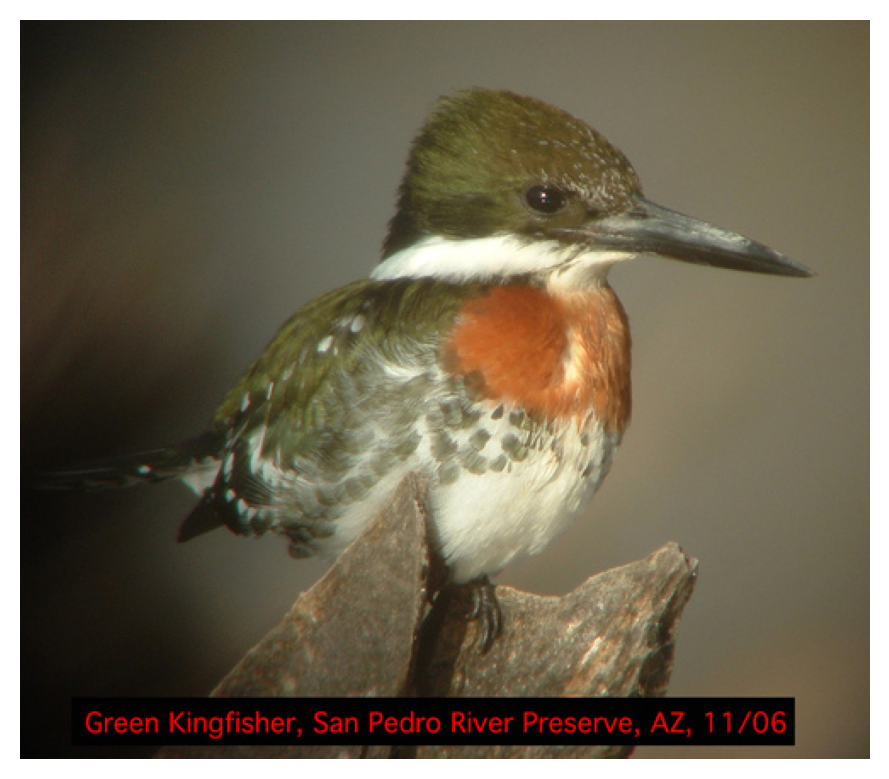

In [41]:
formatText(predict(loaded_model, "CUB_200_2011/images/080.Green_Kingfisher/Green_Kingfisher_0027_71048.jpg", show_img=True))

tensor([53], device='cuda:0')


'Blue_Grosbeak'

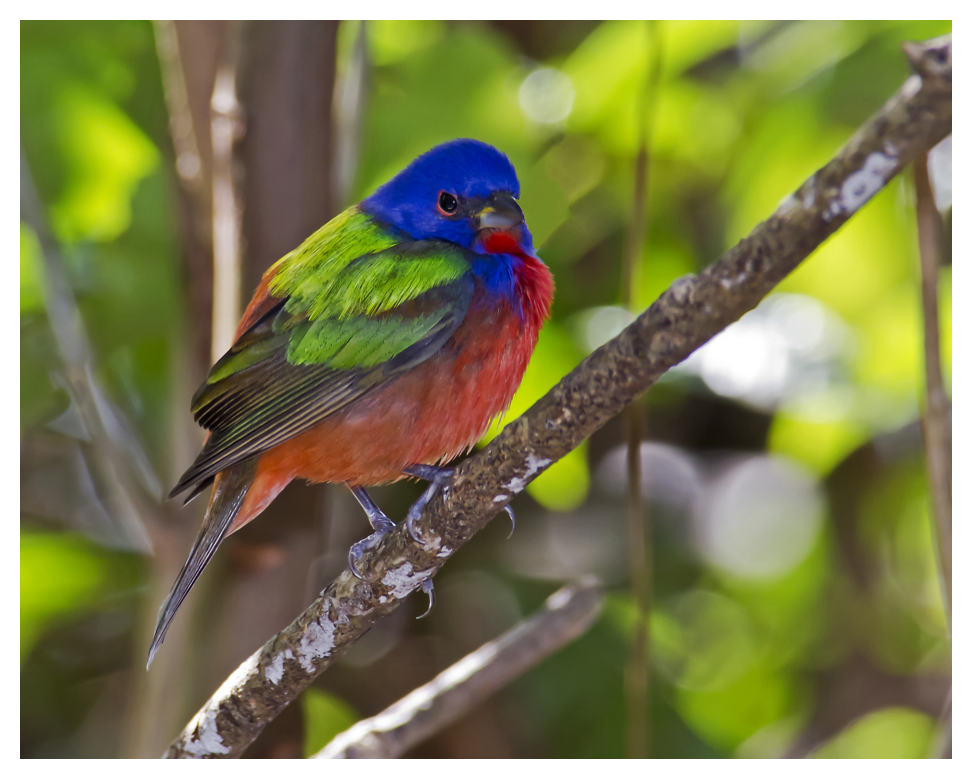

In [42]:
formatText(predict(loaded_model, "https://cdn.birdwatchingdaily.com/2013/06/MalePaintedBunting.jpg", show_img=True, url=True))

In [57]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if torch.cuda.is_available():
    images = images.cuda()

# get sample outputs
output = model_ft(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15, 10))
for idx in np.arange(10):
    ax = fig.add_subplot(10, 2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
    ax.set_title("{} ({})".format(formatText(classes[preds[idx]]), formatText(classes[labels[idx]])),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [58]:
images[0]

tensor([[[-1.3987, -1.5014, -1.5185,  ..., -0.6452, -0.7650, -0.8164],
         [-1.4500, -1.5014, -1.5185,  ..., -0.7822, -0.8507, -0.8335],
         [-1.5014, -1.5014, -1.4843,  ..., -0.7650, -0.8335, -0.8164],
         ...,
         [-0.2171, -0.1999, -0.0801,  ...,  0.9474,  0.9303,  0.8961],
         [-0.1828, -0.1999, -0.1314,  ...,  0.9817,  0.9817,  0.9646],
         [-0.2171, -0.1657, -0.1486,  ...,  1.0502,  1.0673,  1.0502]],

        [[-1.2654, -1.3704, -1.3880,  ...,  0.2752,  0.1527,  0.0651],
         [-1.3354, -1.3704, -1.3880,  ...,  0.1352,  0.1001,  0.0826],
         [-1.3880, -1.4055, -1.3704,  ...,  0.1176,  0.1176,  0.1001],
         ...,
         [ 0.3452,  0.3277,  0.4153,  ...,  1.0455,  1.0630,  1.0280],
         [ 0.3803,  0.3452,  0.4153,  ...,  1.0805,  1.0630,  1.0630],
         [ 0.3803,  0.3978,  0.3978,  ...,  1.1155,  1.0980,  1.0980]],

        [[-1.2641, -1.3687, -1.3164,  ..., -0.6193, -0.7238, -0.6890],
         [-1.2641, -1.3513, -1.3513,  ..., -0